# pure QCD flow for 3b1f

**Goal:** Combine most of the code + validation plots in the `val-3b1` nb w/ the new approach of the `Pure-QCD-flow` nb.


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.optimize import curve_fit

import os

os.sys.path += ['../non-resonant-studies/','../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from utils import f, f_2comp

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

# import cabinetry
# cabinetry.set_logging()
# import pyhf

import hist

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *


%load_ext autoreload
%autoreload 2

Using uproot4


In [3]:
colors = [
    'dodgerblue',
    'darkorange',
    'limegreen',
    'crimson',
    'mediumpurple',
    'brown',
    'deeppink',
    'grey',
    'darkgoldenrod',
    'mediumturquoise'
]

In [4]:
c = 'val1p1'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

nSeeds = 25

yrs = ['16','17','18']

In [5]:
hdict = {i: {yr:{} for yr in yrs} for i in range(10)} # GP + flow prediction
hAll = {i: {} for i in range(10)}

for i in range(10):
    
    subDir = f'qcd161718-MAY21_3b1f_{i}of10_detaCut_ggf'
    modelDir = f'../gp-for-flows/models/{subDir}'

    for yr in yrs:
        with open(f'{modelDir}/{modelConfig}/hists_gp_100k_{yr}.json','r') as hfile:
            out = json.load(hfile)

        for k in out.keys():
            hdict[i][yr][k] = np.array( out[k])
            
            
    for k in hdict[i]['16'].keys():
        if 'std' in k: 
            continue

        hAll[i][k] = np.vstack([hd[k] for yr,hd in hdict[i].items()]).sum(axis=0)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
        k = f'{c}_SR{tag}'

        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))

Let's also load in the inclusively trained networks (using "i" to denote "inclusive").

In [6]:
idict = {i: {yr:{} for yr in yrs} for i in range(10)} # GP + flow prediction

iAll = {i: {} for i in range(10)}

for i in range(10):
    
    subDir = f'data161718-MAY21_3b1f_{i}of10_detaCut_ggf'
    modelDir = f'../gp-for-flows/models/{subDir}'

    
    for yr in yrs:
        with open(f'{modelDir}/{modelConfig}/hists_gp_100k_{yr}.json','r') as hfile:
            out = json.load(hfile)

        for k in out.keys():
            idict[i][yr][k] = np.array( out[k])
            
            
    for k in idict[i]['16'].keys():
        if 'std' in k: 
            continue
        iAll[i][k] = np.vstack([hd[k] for yr,hd in idict[i].items()]).sum(axis=0)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
        k = f'{c}_SR{tag}'

        # Correlated errors
        stack = np.vstack([iAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        iAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - iAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))

**Load i the data**

In [7]:
fnames = [f'../data/RR/cryptotuples/data{yr}.root' for yr in yrs]

hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = ['ntag','X_wt_tag','pass_vbf_sel','minQ','event_number',"passMuonIso"]
load_cols = load_cols + d_cols+hc_vars

In [8]:
myRanges,edg_3d = get_default_bins()

In [9]:
dfs = []

for fname in fnames:
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi['sig'].arrays(load_cols,library='pd')
        mi = dfi.eval('ntag == 3 & minQ == 1 & ~pass_vbf_sel')


        dfs.append( dfi[mi] )
        
dat = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/data16.root
../data/RR/cryptotuples/data17.root
../data/RR/cryptotuples/data18.root


In [10]:
ahnames = [f'../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16{yr_to_mc[yr]}/NanoNTuple.root' for yr in yrs]
slnames = [f'../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16{yr_to_mc[yr]}/NanoNTuple.root' for yr in yrs]

In [11]:
dfs = []

for yr,fname in zip(yrs,ahnames):
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi['sig'].arrays(load_cols+['mc_sf'],library='pd')
        mi = dfi.eval('ntag == 3 & minQ == 1 & ~pass_vbf_sel')

        dfi['mc_sf'] *= lumi[yr]
        
        dfs.append( dfi[mi] )
        
ah = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16a/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16d/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16e/NanoNTuple.root


In [12]:
lumi[yr]

57.7

In [13]:
dfs = []

for yr,fname in zip(yrs,slnames):
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi['sig'].arrays(load_cols+['mc_sf'],library='pd')
        mi = dfi.eval('ntag == 3 & minQ == 1 & ~pass_vbf_sel')

        dfi['mc_sf'] *= lumi[yr]
            
        dfs.append( dfi[mi] )
        
sl = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16a/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16d/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16e/NanoNTuple.root


In [14]:
for i in range(10):
    
    
    # Get the by year norms
    ns = np.array([0.1 * np.sum(dfi['X_wt_tag'] < 1.5) / np.sum(hdict[i][yr]['X_wt_tag_SR_mean'][:10]) 
          for yr, dfi in zip(yrs, dfs)])

    print(ns)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):

        k = f'{c}_SR{tag}'

        # Weighted mean
        hAll[i][f"{k}_wmean"] = np.sum(np.vstack([n*hdict[i][yr][f'{k}_mean'] 
                                                  for yr, n in zip(yrs,ns)]),axis=0)
        
        for j in range(nSeeds):
            hAll[i][f'{k}_w{j}'] = np.sum(np.vstack([n*hdict[i][yr][f'{k}_{j}'] 
                                                    for yr, n in zip(yrs,ns)]),axis=0)
        
        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_w{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_wstd"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_wmean'])**2, axis=0) / (nSeeds-1))



[2.02308567 1.72403468 1.5707101 ]
[2.17615986 1.73832055 1.5075898 ]
[2.13167221 1.74053548 1.65659822]
[2.16814478 1.69692597 1.4800526 ]
[1.89181211 1.57955356 1.43435192]
[2.16682744 1.79354354 1.53357847]
[2.173833   1.75252424 1.46994041]
[2.17292491 1.71713349 1.47932557]
[1.84594948 1.57166174 1.49846761]
[2.2096216  1.71563122 1.44391266]


In [15]:
chi2 = pd.DataFrame(0,range(10),['incl','pure qcd','post-fit'])

findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


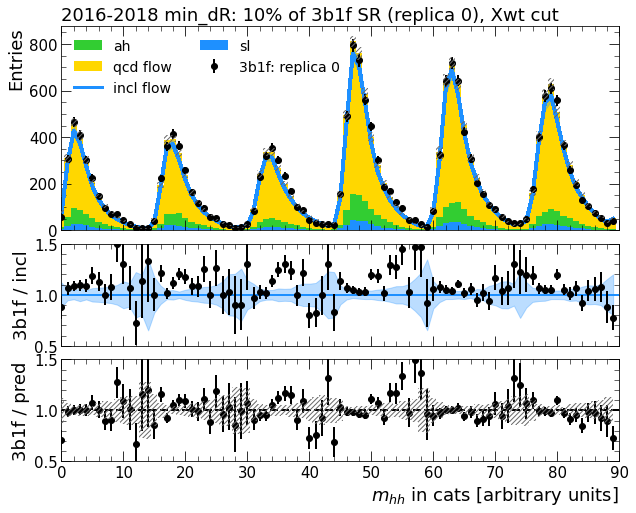

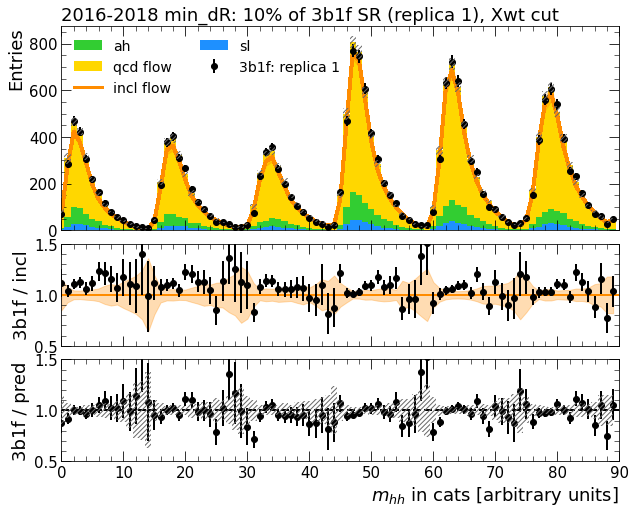

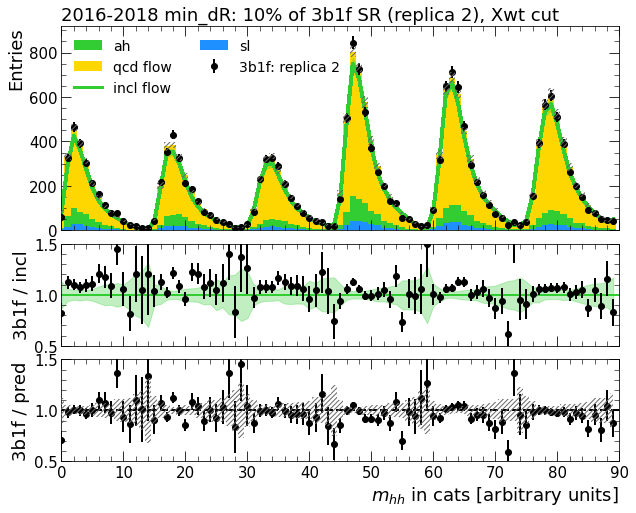

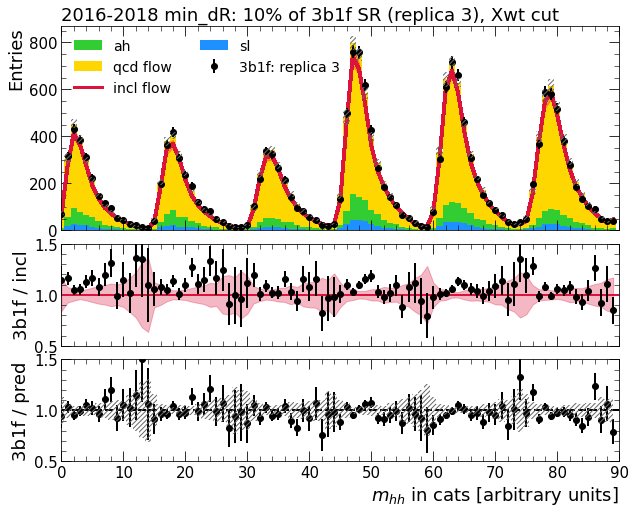

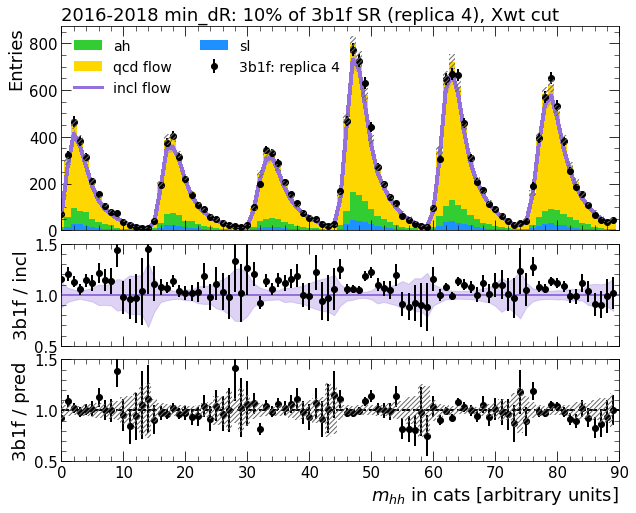

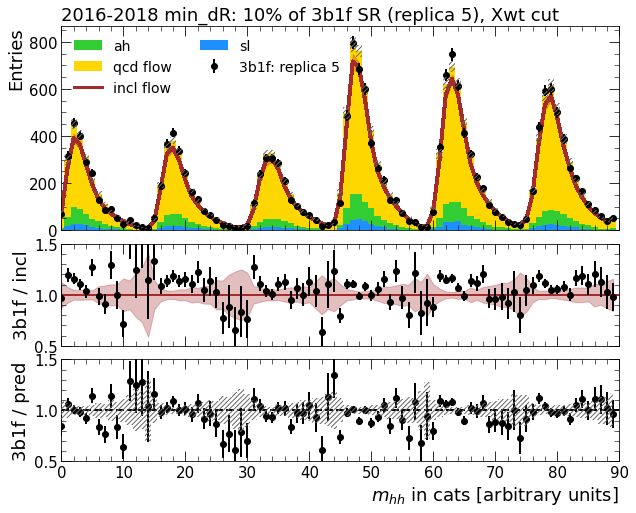

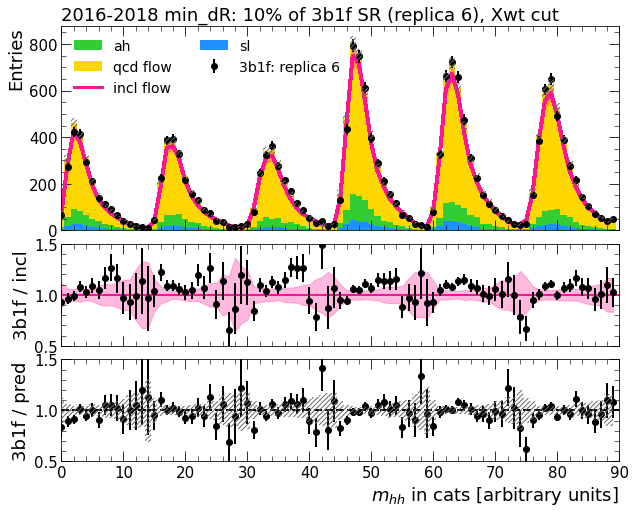

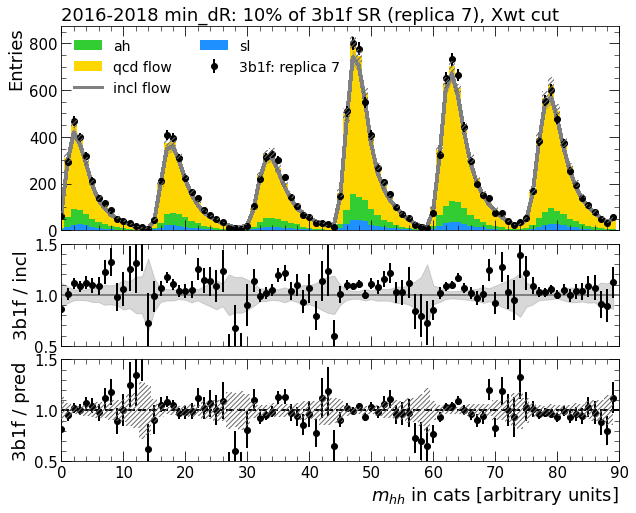

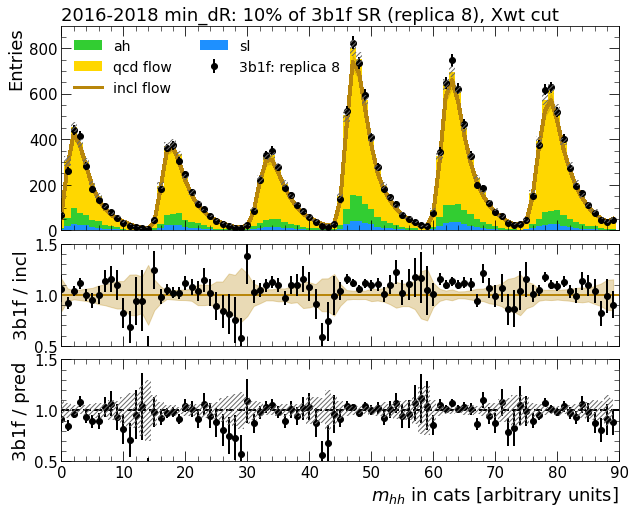

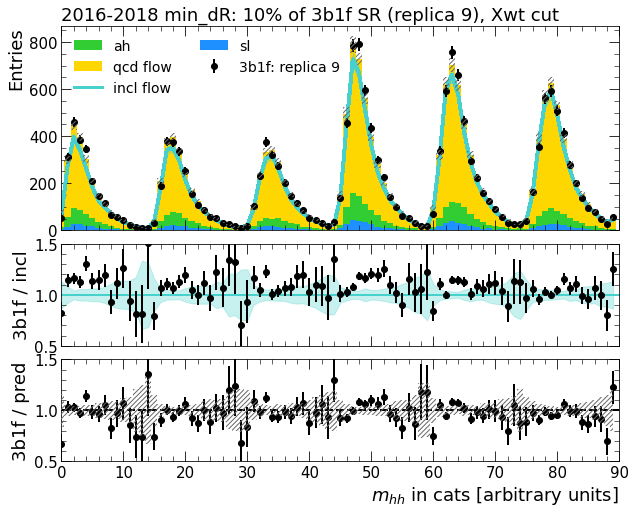

In [16]:
for i in range(10):
    k = '_SR_Xwt_cut'


    fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,8),nrows=3,sharex=True,
                                  gridspec_kw={"height_ratios": 
                                               [.5,.25,.25],
                                               "hspace":0.1})

    # ttbar templates
    m_ah = ah.eval(f'X_wt_tag > 1.5 & event_number % 10 == {i}')
    h_3d_ah = np.histogramdd(ah.loc[m_ah,d_cols].values,
                             edg_3d,
                             weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_3d_ah = np.sqrt(
                    np.histogramdd(
                        ah.loc[m_ah,d_cols].values,
                        edg_3d,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(f'X_wt_tag > 1.5 & event_number % 10 == {i}')
    h_3d_sl = np.histogramdd(sl.loc[m_sl,d_cols].values,
                             edg_3d,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_3d_sl = np.sqrt(
                    np.histogramdd(
                        sl.loc[m_sl,d_cols].values,
                        edg_3d,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']

    h_prev = 0
    for hi, ci, li in zip([h_3d_sl,h_3d_ah,nom],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(range(len(nom)),np.arange(-.5,len(nom)+.5,1),
                 weights=hi,bottom=h_prev,color=ci,label=li)
        h_prev+=hi


    '''
    Overlay model err
    '''
    err = np.sqrt(std**2+dh_3d_ah**2+dh_3d_sl**2)

    ax1.fill_between(range(len(nom)),h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax3.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')

    ax3.plot([0,len(nom)], [1]*2,lw=2,color='k',ls='--')

    '''
    Inclusively trained flow
    '''
    nom = iAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = iAll[i][f'X_hh_dEta_hh_m_hh{k}_std']
    c = colors[i]

    ax1.plot(nom,color=c,label=f'incl flow',lw=3)   

    ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3)
    ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color=c,alpha=0.3)

    ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

    '''
    Obs data
    '''
    mask = dat.eval(f'X_wt_tag > 1.5 & event_number % 10 == {i}')

    h_3d = np.histogramdd(dat.loc[mask,d_cols].values,edg_3d)[0].flatten()

    # For later analysis, let's add the chi^2 entries
    chi2.loc[i,'incl'] = np.sum( (h_3d - nom)**2 / nom )
    chi2.loc[i,'pure qcd'] = np.sum( (h_3d - h_prev)**2 / h_prev )
    
    ax1.errorbar(range(len(nom)), h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')

    ax2.errorbar(range(len(nom)), h_3d/nom, np.sqrt(h_3d)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')
    ax3.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax3.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018 min_dR: 10% of 3b1f SR (replica {i}), Xwt cut',x=0,loc='left')

    ax2.set_ylabel('3b1f / incl',fontsize=18)
    ax3.set_ylabel('3b1f / pred',fontsize=18)

    handles, labels = ax1.get_legend_handles_labels()
    order = [1,2,3,0,4]
    ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=2)

    ax1.set_xlim(0,90)
    ax2.set_ylim(0.5,1.5)
    ax3.set_ylim(0.5,1.5)

    plt.savefig(f'figures/qcd161718-MAY21_3b1f_{i}of1_detaCut_ggf/m_hh_cats_prefit_cf_incl.pdf',bbox_inches='tight')
    plt.show()

In [17]:
chi2/90

incl  pure qcd  post-fit
0  2.925543  1.428947       0.0
1  1.942076  0.954015       0.0
2  2.084540  1.264032       0.0
3  1.984722  0.940980       0.0
4  2.412715  0.994559       0.0
5  3.057129  1.637881       0.0
6  2.046224  0.983783       0.0
7  2.185858  1.278626       0.0
8  2.121999  1.001526       0.0
9  2.984052  1.279592       0.0

**Next:** Let's plot the `X_wt_tag` distributions to see if we've _resolved_ the shape modelling issues there.

In [18]:
bi = np.linspace(0,7.5,51)
xi = 0.5 * (bi[1:] + bi[:-1])

In [19]:
xwt_dict     = {}
xwt_unb_dict = {}

In [20]:
bi[:11]

array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ])

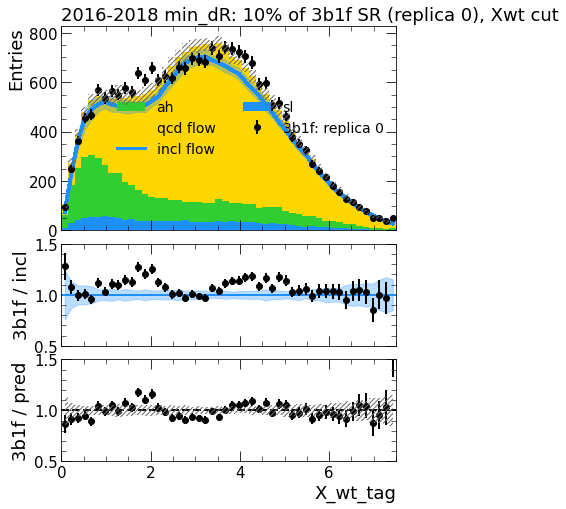

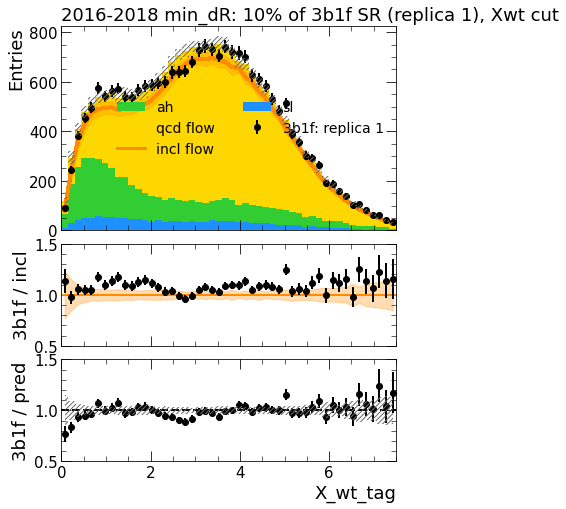

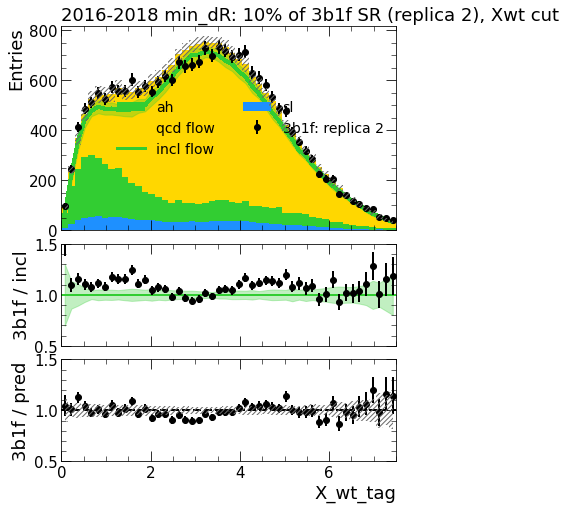

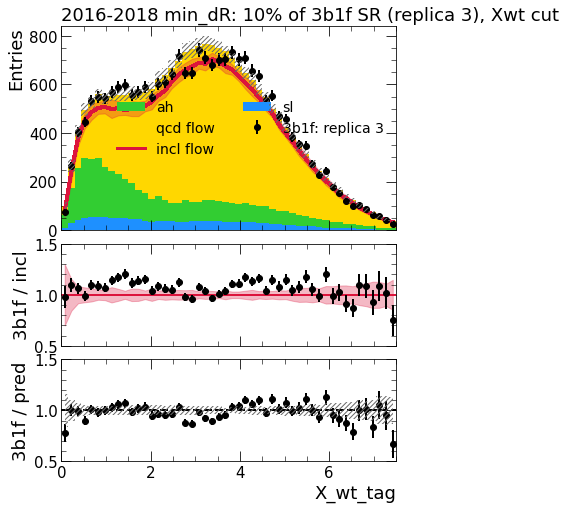

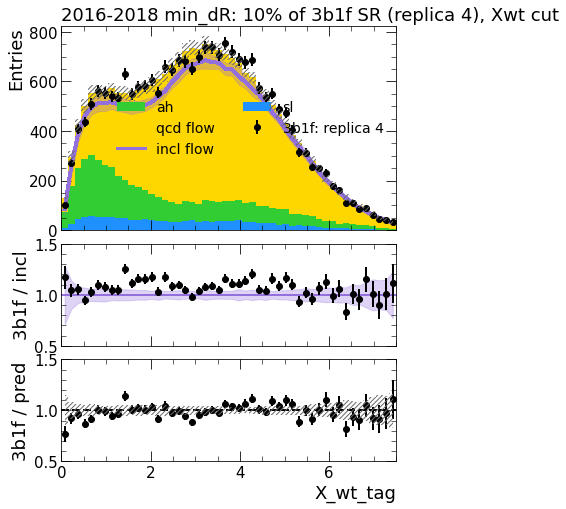

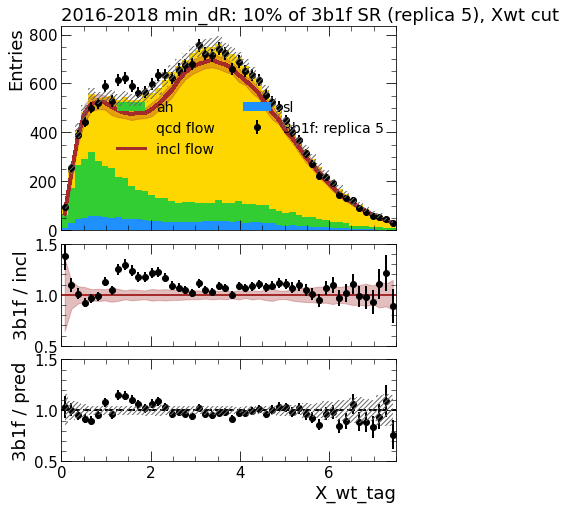

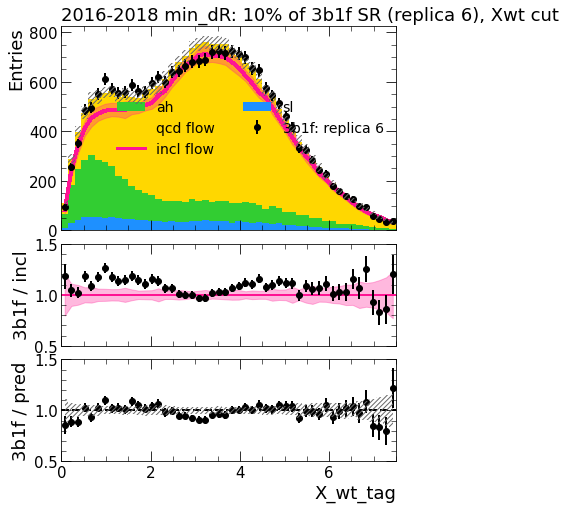

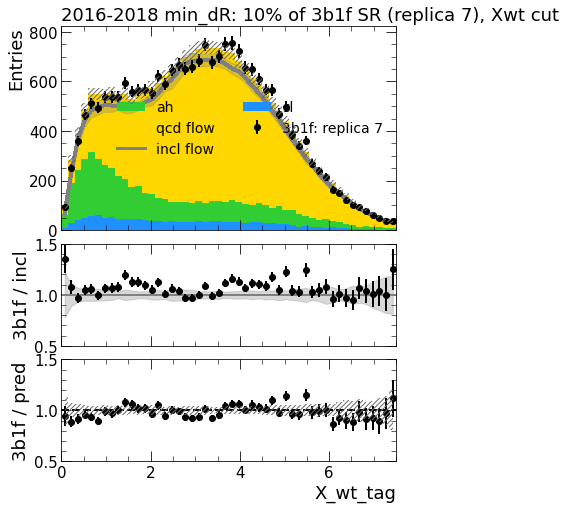

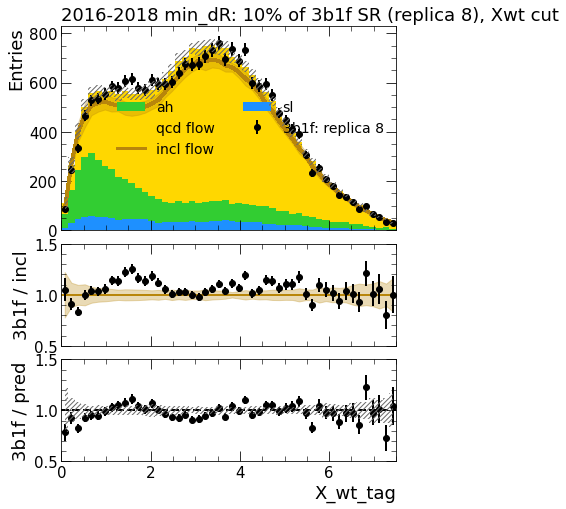

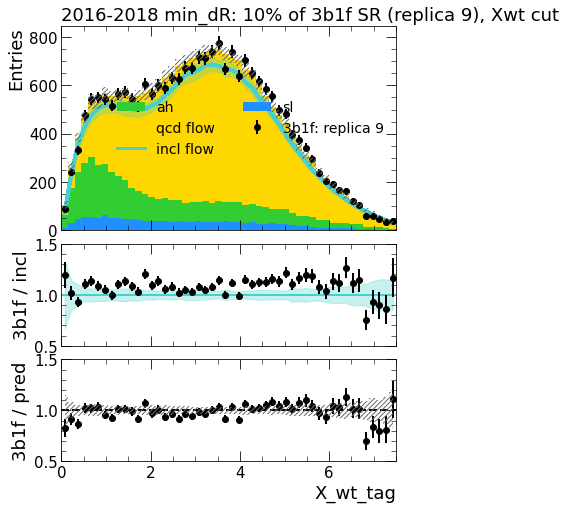

In [21]:
for i in range(10):
    
    fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,8),nrows=3,sharex=True,
                                  gridspec_kw={"height_ratios": [.5,.25,.25],
                                               "hspace":0.1})
    
    # ttbar templates
    m_ah = ah.eval(f'event_number % 10 == {i}')
    h_ah = np.histogram(ah.loc[m_ah,'X_wt_tag'].values,
                           bi,
                        weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_ah = np.sqrt(
                    np.histogram(
                        ah.loc[m_ah,'X_wt_tag'].values,
                        bi,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(f'event_number % 10 == {i}')
    h_sl = np.histogram(sl.loc[m_sl,'X_wt_tag'].values,
                             bi,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_sl = np.sqrt(
                    np.histogram(
                        sl.loc[m_sl,'X_wt_tag'].values,
                        bi,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    qcd = hAll[i][f'X_wt_tag_SR_mean']
    dqcd = hAll[i][f'X_wt_tag_SR_std']

    h_prev = 0
    for hi, ci, li in zip([h_sl,h_ah,qcd],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(xi,bi,weights=hi,bottom=h_prev,color=ci,label=li)
        h_prev+=hi


    '''
    Overlay model err
    '''
    err = np.sqrt(dqcd**2+dh_ah**2+dh_sl**2)

    ax1.fill_between(xi,h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax3.fill_between(xi,1+err/h_prev,1-err/h_prev,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')

    ax3.plot(bi[[0,-1]], [1]*2,lw=2,color='k',ls='--')

    '''
    Inclusively trained flow
    '''
    nom = iAll[i][f'X_wt_tag_SR_mean']
    std = iAll[i][f'X_wt_tag_SR_std']
    c = colors[i]

    ax1.plot(xi,nom,color=c,label=f'incl flow',lw=3)   

    ax1.fill_between(xi,  nom+std,  nom-std,color=c,alpha=0.3)
    ax2.fill_between(xi,1+std/nom,1-std/nom,color=c,alpha=0.3)

    ax2.plot(bi[[0,-1]], [1]*2,lw=2,color=c)

    '''
    Obs data
    '''
    mask = dat.eval(f'event_number % 10 == {i}')

    h_3d = np.histogram(dat.loc[mask,'X_wt_tag'].values,bi)[0].flatten()

    # For later analysis, let's add the chi^2 entries
    chi2.loc[i,'incl'] = np.sum( (h_3d - nom)**2 / nom )
    chi2.loc[i,'pure qcd'] = np.sum( (h_3d - h_prev)**2 / h_prev )
    
    # Also - let's save the info for the shape fit!
    xwt_dict[ f'sl_sr_3b1f_{i}'] = h_sl[:10]
    xwt_dict[ f'ah_sr_3b1f_{i}'] = h_ah[:10]
    xwt_dict[f'qcd_sr_3b1f_{i}'] = qcd[:10]
    
    xwt_dict[ f'sl_sr_3b1f_{i}_err'] = dh_sl[:10]
    xwt_dict[ f'ah_sr_3b1f_{i}_err'] = dh_ah[:10]
    xwt_dict[f'qcd_sr_3b1f_{i}_err'] = dqcd[:10]
    
    xwt_dict[f'dat_sr_3b1f_{i}'] = h_3d[:10]
    
    xwt_unb_dict[ f'sl_sr_3b1f_{i}'] = h_sl
    xwt_unb_dict[ f'ah_sr_3b1f_{i}'] = h_ah
    xwt_unb_dict[f'qcd_sr_3b1f_{i}'] = qcd
    
    xwt_unb_dict[ f'sl_sr_3b1f_{i}_err'] = dh_sl
    xwt_unb_dict[ f'ah_sr_3b1f_{i}_err'] = dh_ah
    xwt_unb_dict[f'qcd_sr_3b1f_{i}_err'] = dqcd
    
    xwt_unb_dict[f'dat_sr_3b1f_{i}'] = h_3d
        
    ax1.errorbar(xi, h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')

    ax2.errorbar(xi, h_3d/nom, np.sqrt(h_3d)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')
    ax3.errorbar(xi, h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax3.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018 min_dR: 10% of 3b1f SR (replica {i}), Xwt cut',x=0,loc='left')

    ax2.set_ylabel('3b1f / incl',fontsize=18)
    ax3.set_ylabel('3b1f / pred',fontsize=18)

    handles, labels = ax1.get_legend_handles_labels()
    order = [1,2,3,0,4]
    ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=2)

    ax1.set_xlim(0,bi[-1])
    ax2.set_ylim(0.5,1.5)
    ax3.set_ylim(0.5,1.5)

    plt.savefig(f'figures/qcd161718-MAY21_3b1f_{i}of1_detaCut_ggf/X_wt_tag_prefit_cf_incl.pdf',bbox_inches='tight')
    plt.show()

**Q from Michael:** How does this c.f. if we normalize the $X_{Wt}$ histogram?

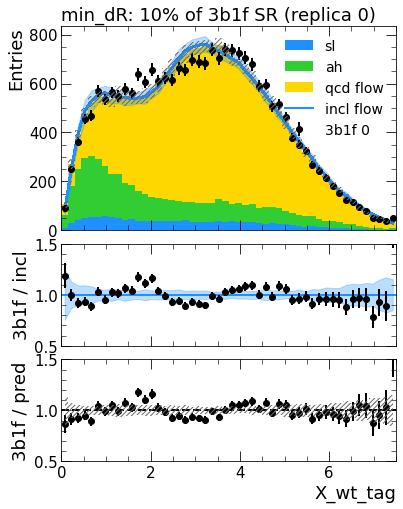

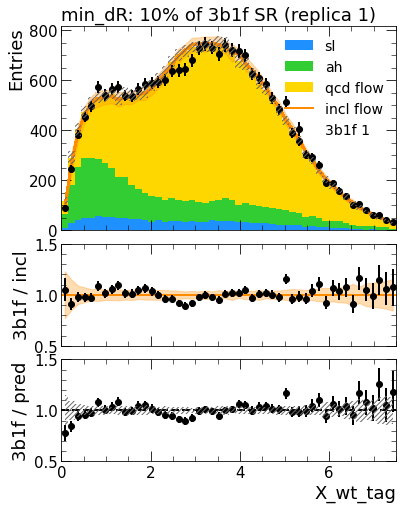

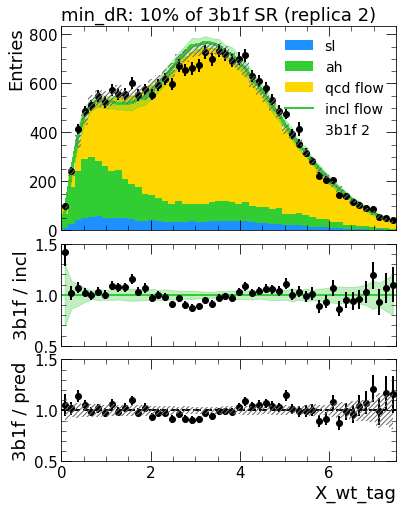

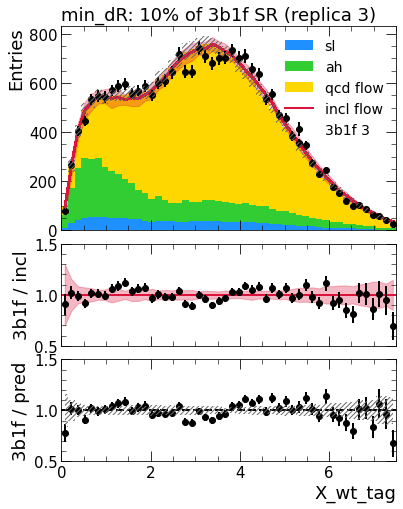

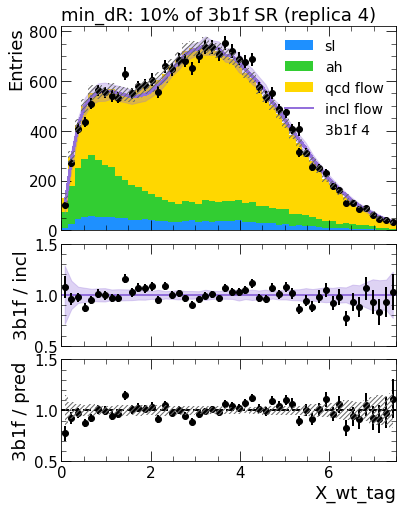

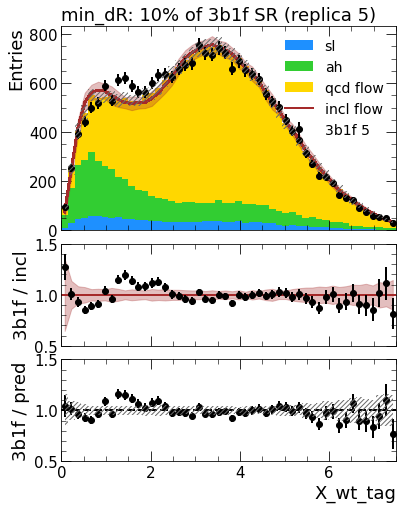

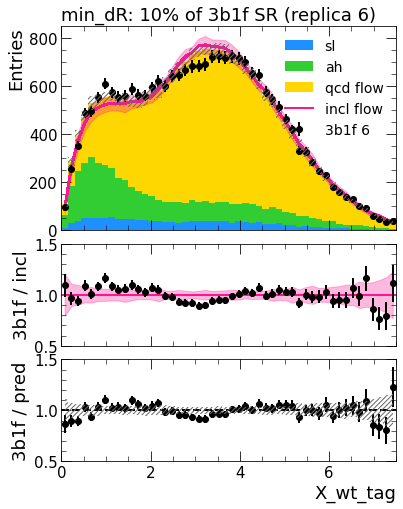

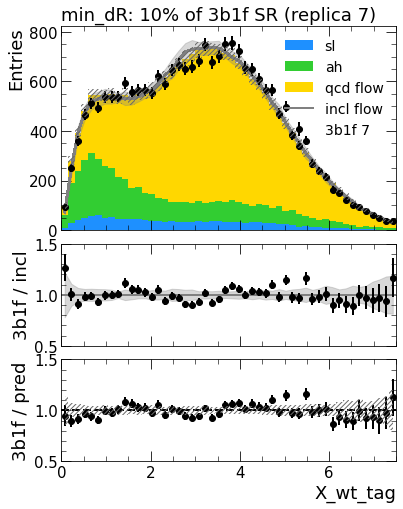

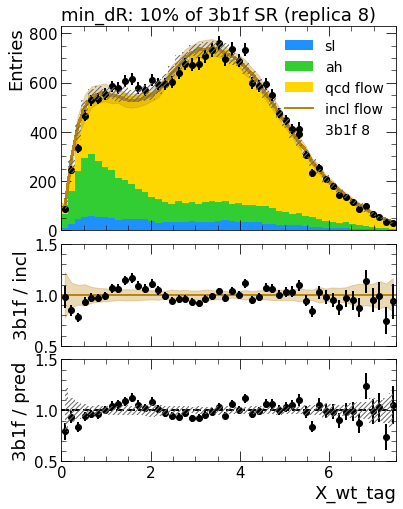

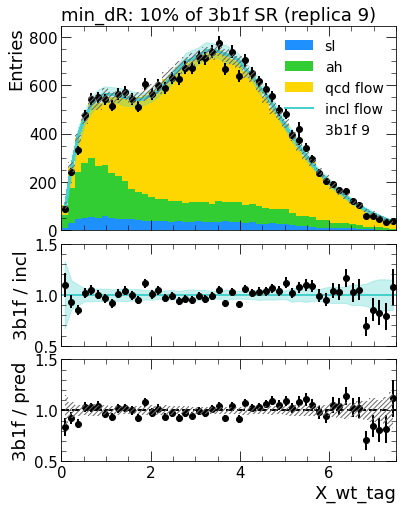

In [51]:
for i in range(10):
    
    fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,8),nrows=3,sharex=True,
                                  gridspec_kw={"height_ratios": [.5,.25,.25],
                                               "hspace":0.1})
    
    '''
    Obs data
    '''
    mask = dat.eval(f'event_number % 10 == {i}')

    h_3d = np.histogram(dat.loc[mask,'X_wt_tag'].values,bi)[0].flatten()
        
    # ttbar templates
    m_ah = ah.eval(f'event_number % 10 == {i}')
    h_ah = np.histogram(ah.loc[m_ah,'X_wt_tag'].values,
                           bi,
                        weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_ah = np.sqrt(
                    np.histogram(
                        ah.loc[m_ah,'X_wt_tag'].values,
                        bi,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(f'event_number % 10 == {i}')
    h_sl = np.histogram(sl.loc[m_sl,'X_wt_tag'].values,
                             bi,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_sl = np.sqrt(
                    np.histogram(
                        sl.loc[m_sl,'X_wt_tag'].values,
                        bi,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    qcd = hAll[i][f'X_wt_tag_SR_mean']
    dqcd = hAll[i][f'X_wt_tag_SR_std']

    '''
    Multiply by an overall normalization (assume that the templates have the same norm factor)
    '''
    bkg = h_sl+h_ah+qcd
    norm = np.sum(h_3d)/np.sum(bkg)
    
    h_prev = 0
    for hi, ci, li in zip([h_sl,h_ah,qcd],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(xi,bi,weights=hi*norm,bottom=h_prev,color=ci,label=li)
        h_prev+=hi*norm


    '''
    Overlay model err
    '''
    err = np.sqrt(dqcd**2+dh_ah**2+dh_sl**2)
    err *= norm
    
    ax1.fill_between(xi,h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax3.fill_between(xi,1+err/h_prev,1-err/h_prev,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')

    ax3.plot(bi[[0,-1]], [1]*2,lw=2,color='k',ls='--')

    '''
    Inclusively trained flow
    '''
    nom = iAll[i][f'X_wt_tag_SR_mean']
    std = iAll[i][f'X_wt_tag_SR_std']
    c = colors[i]

    norm_inc = np.sum(h_3d)/np.sum(nom)
    
    nom *= norm_inc
    std *= norm_inc
    
    ax1.plot(xi,nom,color=c,label=f'incl flow',lw=2)   

    ax1.fill_between(xi,  nom+std,  nom-std,color=c,alpha=0.3)
    ax2.fill_between(xi,1+std/nom,1-std/nom,color=c,alpha=0.3)

    ax2.plot(bi[[0,-1]], [1]*2,lw=2,color=c)

    
    # For later analysis, let's add the chi^2 entries
#     chi2.loc[i,'incl'] = np.sum( (h_3d - norm_inc*nom)**2 / norm_inc *  nom )
#     chi2.loc[i,'pure qcd'] = np.sum( (h_3d - norm * h_prev)**2 / norm * h_prev )
        
    ax1.errorbar(xi, h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f')

    ax2.errorbar(xi, h_3d/nom, np.sqrt(h_3d)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')
    ax3.errorbar(xi, h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax3.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'min_dR: 10% of 3b1f SR (replica {i})',x=0,loc='left')

    ax2.set_ylabel('3b1f / incl',fontsize=18)
    ax3.set_ylabel('3b1f / pred',fontsize=18)

    ax1.legend()

    ax1.set_xlim(0,bi[-1])
    ax2.set_ylim(0.5,1.5)
    ax3.set_ylim(0.5,1.5)

    plt.savefig(f'figures/qcd161718-MAY21_3b1f_{i}of1_detaCut_ggf/X_wt_tag_prefit_cf_incl_norm.pdf',bbox_inches='tight')
    plt.show()

Ok - what I really want to c.f. here are the two subpanels, so put them _together_ rn.

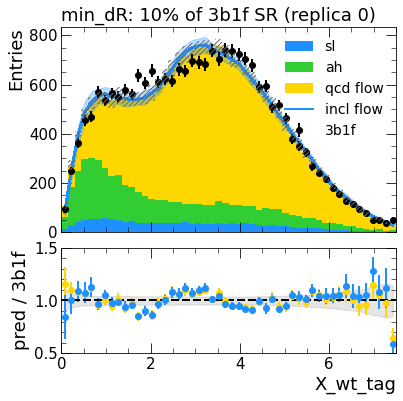

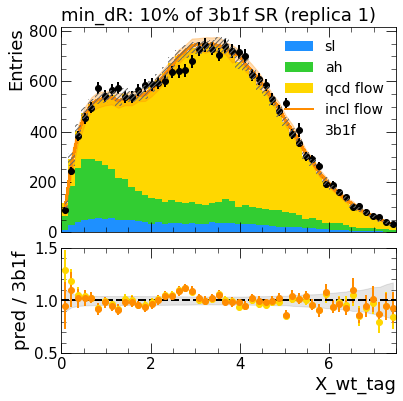

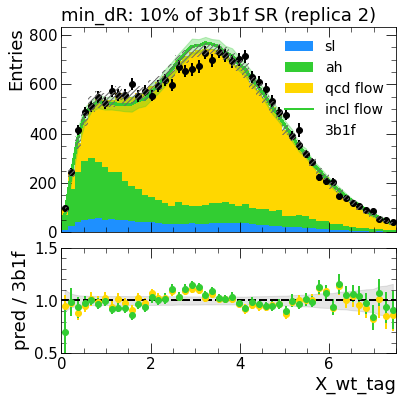

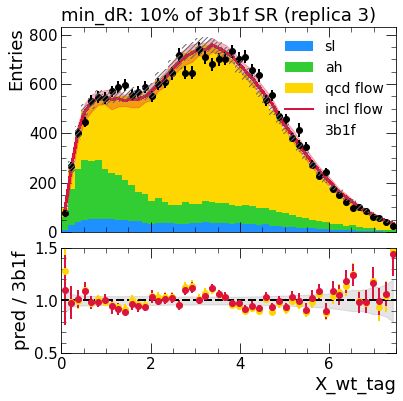

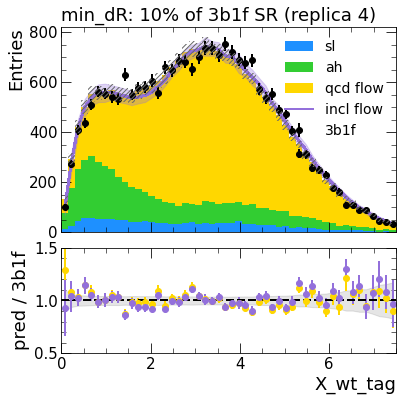

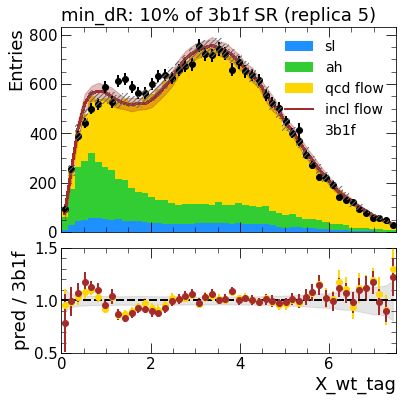

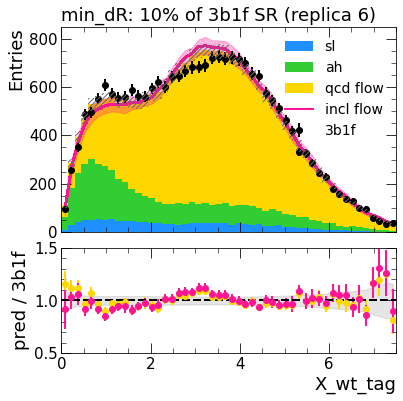

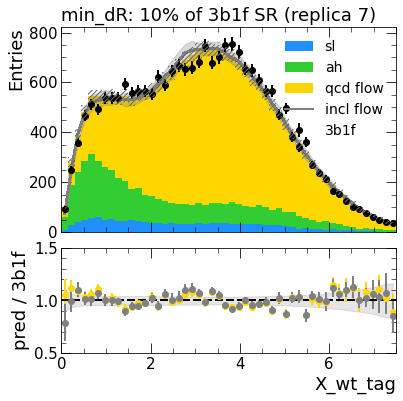

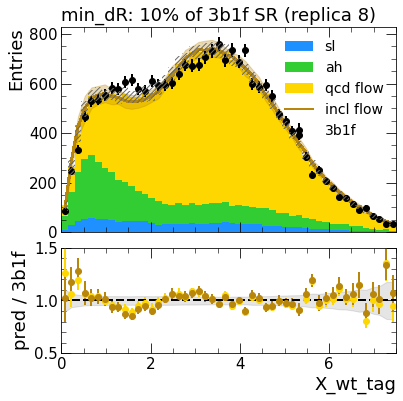

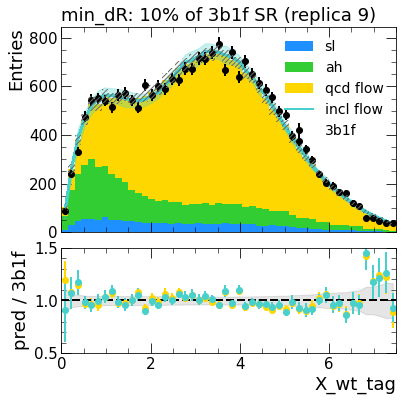

In [62]:
for i in range(10):
    
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})
    
    '''
    Obs data
    '''
    mask = dat.eval(f'event_number % 10 == {i}')

    h_3d = np.histogram(dat.loc[mask,'X_wt_tag'].values,bi)[0].flatten()
        
    # ttbar templates
    m_ah = ah.eval(f'event_number % 10 == {i}')
    h_ah = np.histogram(ah.loc[m_ah,'X_wt_tag'].values,
                           bi,
                        weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_ah = np.sqrt(
                    np.histogram(
                        ah.loc[m_ah,'X_wt_tag'].values,
                        bi,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(f'event_number % 10 == {i}')
    h_sl = np.histogram(sl.loc[m_sl,'X_wt_tag'].values,
                             bi,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_sl = np.sqrt(
                    np.histogram(
                        sl.loc[m_sl,'X_wt_tag'].values,
                        bi,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    qcd = hAll[i][f'X_wt_tag_SR_mean']
    dqcd = hAll[i][f'X_wt_tag_SR_std']

    '''
    Multiply by an overall normalization (assume that the templates have the same norm factor)
    '''
    bkg = h_sl+h_ah+qcd
    norm = np.sum(h_3d)/np.sum(bkg)
    
    h_prev = 0
    for hi, ci, li in zip([h_sl,h_ah,qcd],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(xi,bi,weights=hi*norm,bottom=h_prev,color=ci,label=li)
        h_prev+=hi*norm

    #ax1.hist(xi,bi,weights=hi*norm,bottom=h_prev,color='k',label=li,lw=1.5)
        
    '''
    Overlay model err
    '''
    err = np.sqrt(dqcd**2+dh_ah**2+dh_sl**2)
    err *= norm
    
    ax1.fill_between(xi,h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax2.errorbar(xi,h_prev/h_3d,err/h_3d,
                 lw=0, elinewidth=2,marker='o',color='gold')
#                      fc="None",edgecolor='dimgrey', hatch='/////',
#                      zorder=6,lw=0,step='mid')

    ax2.plot(bi[[0,-1]], [1]*2,lw=2,color='k',ls='--')

    '''
    Inclusively trained flow
    '''
    nom = iAll[i][f'X_wt_tag_SR_mean']
    std = iAll[i][f'X_wt_tag_SR_std']
    c = colors[i]

    norm_inc = np.sum(h_3d)/np.sum(nom)
    
    nom *= norm_inc
    std *= norm_inc
    
    ax1.plot(xi,nom,color=c,label=f'incl flow',lw=2)   

    ax1.fill_between(xi,  nom+std,  nom-std,color=c,alpha=0.3)
#     ax2.fill_between(xi,(nom+std)/h_3d,(nom-std)/h_3d,color=c,alpha=0.3)
    ax2.errorbar(xi,nom/h_3d,std/h_3d, 
                     lw=0, elinewidth=2,marker='o',color=c)




    ax2.plot(bi[[0,-1]], [1]*2,lw=2,color='k',ls='--')
 
    ax1.errorbar(xi, h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f')

    ax2.fill_between(xi, 1+1/np.sqrt(h_3d), 1-1/np.sqrt(h_3d), 
                     color='k',alpha=.1)


    ax2.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'min_dR: 10% of 3b1f SR (replica {i})',x=0,loc='left')

    ax2.set_ylabel('pred / 3b1f',fontsize=18)

    ax1.legend()

    ax1.set_xlim(0,bi[-1])
    ax2.set_ylim(0.5,1.5)

    plt.savefig(f'figures/qcd161718-MAY21_3b1f_{i}of1_detaCut_ggf/X_wt_tag_prefit_cf_incl_norm_1sub.pdf',bbox_inches='tight')
    plt.show()
    #break

I suppose I could do a break down by year, but _honestly_ I think this is sufficient!

**Next:** `X_wt_tag` shape fits

In [23]:
f

<function utils.f(x, p0, p1, p2)>

In [24]:
def getFit(hist_dict,region='sr',target='3b1f',replica=-1,ttbar_inclusive=False):
    '''
    Given the ttbar and data yields, calc the est
    and return the fit result
    '''

    # Get the QCD estimate
    k = f'{region}_{target}'
    if replica != -1:
        k += f'_{replica}'
    
    y = hist_dict[f'dat_{k}']
    
    if ttbar_inclusive:
        x = np.vstack([hist_dict[f'sl_{k}'] + hist_dict[f'ah_{k}'],
                       hist_dict[f'qcd_{k}']])
        p, cov = curve_fit(f_2comp, x, ydata=y, sigma=np.sqrt(y), absolute_sigma=True)
    else:
        x = np.vstack([hist_dict[f'sl_{k}'],
                       hist_dict[f'ah_{k}'],
                       hist_dict[f'qcd_{k}']])

        p, cov = curve_fit(f, x, ydata=y, sigma=np.sqrt(y), absolute_sigma=True)

    return p,cov

In [25]:
#for yr in yrs:

ps = {}
ri='sr'
bcat='3b1f'

print('Fitting Xwt < 1.5')
for replica in range(10):
    p, cov = getFit(xwt_dict,region=ri,target=bcat,replica=replica)

    print(f'replica {replica}, sl = {p[0]: 1.2f}, ah = {p[1]: 1.2f}, qcd = {p[2]: 1.2f}')

Fitting Xwt < 1.5
replica 0, sl =  0.27, ah =  0.80, qcd =  1.28
replica 1, sl =  12.68, ah = -0.84, qcd =  0.16
replica 2, sl =  6.82, ah =  0.23, qcd =  0.50
replica 3, sl =  7.50, ah = -0.19, qcd =  0.71
replica 4, sl =  1.03, ah =  0.56, qcd =  1.27
replica 5, sl =  3.11, ah =  0.30, qcd =  1.19
replica 6, sl =  6.94, ah = -0.14, qcd =  0.80
replica 7, sl = -2.97, ah =  1.27, qcd =  1.48
replica 8, sl =  3.76, ah = -0.01, qcd =  1.23
replica 9, sl = -0.83, ah =  1.16, qcd =  1.19


In [26]:
p, cov = getFit(xwt_dict,region=ri,target=bcat,replica=4)

In [27]:
cov

array([[ 4.11893801, -0.60580264, -0.29722781],
       [-0.60580264,  0.10034728,  0.03513137],
       [-0.29722781,  0.03513137,  0.02879388]])

In [28]:
print('Fitting full Xwt shape')
for replica in range(10):
    p, cov = getFit(xwt_unb_dict,region=ri,target=bcat,replica=replica)

    print(f'replica {replica}, sl = {p[0]: 1.2f}, ah = {p[1]: 1.2f}, qcd = {p[2]: 1.2f}')

Fitting full Xwt shape
replica 0, sl =  4.21, ah =  0.35, qcd =  0.89
replica 1, sl =  3.25, ah =  0.51, qcd =  0.92
replica 2, sl =  3.04, ah =  0.71, qcd =  0.89
replica 3, sl =  5.92, ah =  0.06, qcd =  0.80
replica 4, sl =  0.67, ah =  0.93, qcd =  1.04
replica 5, sl =  6.03, ah = -0.00, qcd =  0.82
replica 6, sl =  5.66, ah =  0.13, qcd =  0.82
replica 7, sl =  2.70, ah =  0.56, qcd =  0.96
replica 8, sl =  4.52, ah =  0.22, qcd =  0.88
replica 9, sl = -0.03, ah =  1.13, qcd =  1.04


Ack - this looks horrible

**Next try:** Let's go with a 2 step approach:

1. Fit the semi-leptonic bit using the isolated muon sample
2. Do a 2 component shape fit for the ah + QCD piece


In [29]:
sl.columns

Index(['entry', 'subentry', 'ntag', 'X_wt_tag', 'pass_vbf_sel', 'minQ',
       'event_number', 'passMuonIso', 'X_hh', 'dEta_hh', 'm_hh', 'pT_h1',
       'pT_h2', 'eta_h1', 'eta_h2', 'phi_h1', 'phi_h2', 'mc_sf'],
      dtype='object')

In [30]:
m_sl = sl.passMuonIso & (sl.event_number % 10 == replica) & (sl.X_wt_tag < 1.5)

In [31]:
sl.loc[m_sl,'mc_sf'].sum()

60.22614624462949

In [32]:
m_dat = dat.passMuonIso & (dat.event_number % 10 == replica) & (dat.X_wt_tag < 1.5)

In [33]:
np.sum(m_dat)

61

In [34]:
alpha = np.sum(m_dat)/sl.loc[m_sl,'mc_sf'].sum()

In [35]:
alpha

1.0128491328704186

In [36]:
def fit_ah_qcd(hist_dict,region='sr',target='3b1f',replica=-1, alpha=1,ttbar_inclusive=False):
    '''
    Given the ttbar and/
    data yields, calc the est
    and return the fit result
    '''

    # Get the QCD estimate
    k = f'{region}_{target}'
    if replica != -1:
        k += f'_{replica}'
    
    #print(f'Constraining the sl piece to have proportion {alpha}')    
        
    y = hist_dict[f'dat_{k}'] - alpha * hist_dict[f'sl_{k}']
    dy = np.sqrt(y + (alpha * hist_dict[f'sl_{k}_err'])**2)
    if ttbar_inclusive:
        #raise NotImplementedError
        x = np.vstack([hist_dict[f'sl_{k}'] + hist_dict[f'ah_{k}'],
                       hist_dict[f'qcd_{k}']])
        p, cov = curve_fit(f_2comp, x, ydata=y, sigma=np.sqrt(y), absolute_sigma=True)
    else:
        x = np.vstack([hist_dict[f'ah_{k}'],
                       hist_dict[f'qcd_{k}']])

        p, cov = curve_fit(f_2comp, x, ydata=y, sigma=dy, absolute_sigma=True)

    return p,cov

In [37]:
replica

9

In [38]:
print('Fitting comb ah+sl  Xwt < 1.5')
for replica in range(10):
    
    m_sl = sl.passMuonIso & (sl.event_number % 10 == replica) & (sl.X_wt_tag < 1.5)
    m_dat = dat.passMuonIso & (dat.event_number % 10 == replica) & (dat.X_wt_tag < 1.5)
    
    alpha = np.sum(m_dat)/sl.loc[m_sl,'mc_sf'].sum()
    
    p, cov = fit_ah_qcd(xwt_dict,region=ri,target=bcat,replica=replica,alpha=alpha)

    print(f'replica {replica}, sl = {alpha: 1.2f}, ah = {p[0]: 1.2f}, qcd = {p[1]: 1.2f}')

Fitting comb ah+sl  Xwt < 1.5
replica 0, sl =  0.96, ah =  0.70, qcd =  1.23
replica 1, sl =  1.07, ah =  0.69, qcd =  1.21
replica 2, sl =  0.83, ah =  1.13, qcd =  0.95
replica 3, sl =  0.85, ah =  0.75, qcd =  1.24
replica 4, sl =  0.90, ah =  0.58, qcd =  1.28
replica 5, sl =  1.11, ah =  0.62, qcd =  1.32
replica 6, sl =  1.28, ah =  0.68, qcd =  1.21
replica 7, sl =  1.13, ah =  0.66, qcd =  1.19
replica 8, sl =  1.17, ah =  0.46, qcd =  1.34
replica 9, sl =  1.01, ah =  0.83, qcd =  1.09


In [39]:
print('Fitting comb ah+sl  full Xwt shape')

for replica in range(10):
    
    m_sl = sl.passMuonIso & (sl.event_number % 10 == replica) 
    m_dat = dat.passMuonIso & (dat.event_number % 10 == replica) 
    
    alpha = np.sum(m_dat)/sl.loc[m_sl,'mc_sf'].sum()
    
    p, cov = fit_ah_qcd(xwt_unb_dict,region=ri,target=bcat,replica=replica,alpha=alpha)

    print(f'replica {replica}, sl = {alpha: 1.2f}, ah = {p[0]: 1.2f}, qcd = {p[1]: 1.2f}')

Fitting comb ah+sl  full Xwt shape
replica 0, sl =  0.91, ah =  0.97, qcd =  1.01
replica 1, sl =  0.98, ah =  0.94, qcd =  1.00
replica 2, sl =  0.98, ah =  1.10, qcd =  0.96
replica 3, sl =  0.90, ah =  1.01, qcd =  0.99
replica 4, sl =  0.99, ah =  0.86, qcd =  1.02
replica 5, sl =  0.96, ah =  1.02, qcd =  0.98
replica 6, sl =  1.04, ah =  0.98, qcd =  0.99
replica 7, sl =  1.02, ah =  0.87, qcd =  1.02
replica 8, sl =  0.96, ah =  0.91, qcd =  1.00
replica 9, sl =  0.93, ah =  0.93, qcd =  1.01


In [40]:
cov

array([[ 0.00172216, -0.00037648],
       [-0.00037648,  0.0001545 ]])

In [41]:
corr = cov.copy()

s0, s1 = np.sqrt(np.diag(cov))

corr[0,1] /= (s0*s1)
corr[1,0] /= (s0*s1)

corr[0,0] = 1
corr[1,1] = 1

In [42]:
corr

array([[ 1.        , -0.72984561],
       [-0.72984561,  1.        ]])

**Thoughts:**
1. These templates are not robust before or after the Xwt cut, _or_ between the replicas

**Idea:** I could add stat error to see if this is expected to w/in stat uncertainty?

In [43]:
hist_dict= xwt_dict

print(f'Fitting comb ah+sl Xwt <1.5 shape')

for replica in range(10):

    m_sl = sl.passMuonIso & (sl.event_number % 10 == replica) & (sl.X_wt_tag < 1.5)
    m_dat = dat.passMuonIso & (dat.event_number % 10 == replica) & (dat.X_wt_tag < 1.5)

    alpha = np.sum(m_dat)/sl.loc[m_sl,'mc_sf'].sum()

    k = f'{ri}_{bcat}_{replica}'
    y = hist_dict[f'dat_{k}'] - alpha * (hist_dict[f'sl_{k}']+hist_dict[f'ah_{k}'])

    norm = np.sum(y) / np.sum(hist_dict[f'qcd_{k}'])

    print(f'replica {replica}, ttbar = {alpha: 1.2f}, qcd = {norm: 1.6f}')

Fitting comb ah+sl Xwt <1.5 shape
replica 0, ttbar =  0.96, qcd =  1.008137
replica 1, ttbar =  1.07, qcd =  0.887091
replica 2, ttbar =  0.83, qcd =  1.231208
replica 3, ttbar =  0.85, qcd =  1.162552
replica 4, ttbar =  0.90, qcd =  1.027749
replica 5, ttbar =  1.11, qcd =  0.902262
replica 6, ttbar =  1.28, qcd =  0.699286
replica 7, ttbar =  1.13, qcd =  0.792373
replica 8, ttbar =  1.17, qcd =  0.780211
replica 9, ttbar =  1.01, qcd =  0.941577


In [44]:
hist_dict= xwt_unb_dict

print(f'Fitting comb ah+sl full Xwt shape')

for replica in range(10):

    m_sl = sl.passMuonIso & (sl.event_number % 10 == replica) 
    m_dat = dat.passMuonIso & (dat.event_number % 10 == replica) 

    alpha = np.sum(m_dat)/sl.loc[m_sl,'mc_sf'].sum()

    k = f'{ri}_{bcat}_{replica}'
    y = hist_dict[f'dat_{k}'] - alpha * (hist_dict[f'sl_{k}']+hist_dict[f'ah_{k}'])

    norm = np.sum(y) / np.sum(hist_dict[f'qcd_{k}'])

    print(f'replica {replica}, ttbar = {alpha: 1.2f}, qcd = {norm: 1.6f}')

Fitting comb ah+sl full Xwt shape
replica 0, ttbar =  0.91, qcd =  1.031574
replica 1, ttbar =  0.98, qcd =  0.990640
replica 2, ttbar =  0.98, qcd =  0.995075
replica 3, ttbar =  0.90, qcd =  1.020278
replica 4, ttbar =  0.99, qcd =  0.995497
replica 5, ttbar =  0.96, qcd =  1.003984
replica 6, ttbar =  1.04, qcd =  0.976333
replica 7, ttbar =  1.02, qcd =  0.982107
replica 8, ttbar =  0.96, qcd =  0.996787
replica 9, ttbar =  0.93, qcd =  1.013102


**Next Q:** Need to do a combined fit with the ...